# Training AI agent for Shadaloo Lbyrinth puzzle game

**What is Shadaloo labyrinth?**

The puzzles in Shadaloo Labyrinth are easy to understand but challenging to master. The setup is simple – you need to move around different tiles and you get to (and have to), step on each tile only once before reaching the other side of the labyrinth.


In [1]:
# Import libraries

import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import pylab as pl
from IPython import display

In [2]:
# Dead end checking function

def check_dead_end(obs_map, pos, direction):
    x, y = pos
    tunnel=[]  
    deadend=0
    limit = obs_map.shape[0]-1
    if direction=='down':
        for i in obs_map[x:,y]:
            tunnel.append(i)
            if i == 1:
                break
    elif direction=='up':
        for i in list(obs_map[:x+1,y])[::-1]:
            tunnel.append(i)
            if i == 1:
                break
    elif direction=='left':
        for i in list(obs_map[x,:y+1])[::-1]:
            tunnel.append(i)
            if i == 1:
                break
    elif direction=='right':
        for i in list(obs_map[x,y:]):
            tunnel.append(i)
            if i == 1:
                break
    
    if sum(tunnel)==0:
        tunnel.append(1)
        
    if direction=="down":
        if y==0:
            sidewalk1=list(obs_map[x+1:x+len(tunnel)-1, y+1])
        elif y==limit:
            sidewalk2=list(obs_map[x+1:x+len(tunnel)-1, y-1])
        else:
            sidewalk1=list(obs_map[x+1:x+len(tunnel)-1, y+1])
            sidewalk2=list(obs_map[x+1:x+len(tunnel)-1, y-1])
        check_var=y
    elif direction=="up":
        if y==0:
            sidewalk1=list(obs_map[x-len(tunnel)+2:x, y+1])
        elif y==limit:
            sidewalk2=list(obs_map[x-len(tunnel)+2:x, y-1])
        else:
            sidewalk1=list(obs_map[x-len(tunnel)+2:x, y+1])
            sidewalk2=list(obs_map[x-len(tunnel)+2:x, y-1])
        check_var=y
    elif direction=="right":
        if x==0:
            sidewalk1=list(obs_map[x+1, y+1:y+len(tunnel)-1])
        elif x==limit:
            sidewalk2=list(obs_map[x-1, y+1:y+len(tunnel)-1])
        else:
            sidewalk1=list(obs_map[x+1, y+1:y+len(tunnel)-1])
            sidewalk2=list(obs_map[x-1, y+1:y+len(tunnel)-1])
        check_var=x
    elif direction=="left":
        if x==0:
            sidewalk1=list(obs_map[x+1, y-len(tunnel)+2:y])
        elif x==limit:
            sidewalk2=list(obs_map[x-1, y-len(tunnel)+2:y])
        else:
            sidewalk1=list(obs_map[x+1, y-len(tunnel)+2:y])
            sidewalk2=list(obs_map[x-1, y-len(tunnel)+2:y])
        check_var=x
    
    if len(tunnel)>2:
        wall = list(np.ones(len(tunnel)-2))
        if check_var==0:
            if sidewalk1==wall:
                deadend=1
        elif check_var==limit:
            if sidewalk2==wall:
                deadend=1
        else:
            if sidewalk2==wall and sidewalk1==wall:
                deadend=1
    else:
        deadend=1
    
    return deadend

In [3]:
# Find Hamiltonian path

def findPath(grid, obstacles, curPos, T, visited, path, rows, cols):
    visited[curPos[0]][curPos[1]] = True
    path.append(curPos)

    if curPos == T:
        if len(path) == rows * cols - len(obstacles):
            return path
        else:
            visited[curPos[0]][curPos[1]] = False
            path.pop()
            return None

    for dx, dy in [(0, 1), (0, -1), (1, 0), (-1, 0)]:
        nx = curPos[0] + dx
        ny = curPos[1] + dy

        if 0 <= nx < rows and 0 <= ny < cols and not visited[nx][ny] and grid[nx][ny] != 1:
            newPath = findPath(grid, obstacles, (nx, ny), T, visited, path, rows, cols)
            if newPath:
                return newPath

    visited[curPos[0]][curPos[1]] = False
    path.pop()
    return None


In [4]:
# Dynamic plot function

def plot_grid(optimal_path, wait, grid, obstacle_cells, entry_cell, exit_cell):
    fig, ax = plt.subplots()
    grid_size = grid.shape[0]
    ax.set_xticks(np.arange(-0.5, grid_size, 1))
    ax.set_yticks(np.arange(-0.5, grid_size, 1))
    ax.set_xlim((-0.5,grid_size-1+0.5))
    ax.set_ylim((-0.5,grid_size-1+0.5))
    ax.grid(color='k', linestyle='-', linewidth=1)
    ax.imshow(grid, cmap='gray', extent=[-0.5, grid_size+0.5, -0.5, grid_size+0.5])
    ax.add_patch(plt.Rectangle((entry_cell[0]-0.5, entry_cell[1]-0.5), 1, 1, color='green'))
    ax.scatter(entry_cell[0], entry_cell[1], color='g', marker='o', label='Entry', s=40, zorder=6)
    ax.add_patch(plt.Rectangle((exit_cell[0]-0.5, exit_cell[1]-0.5), 1, 1, color='red'))
    ax.scatter(exit_cell[0], exit_cell[1], color='r', marker='o', label='Exit', s=40, zorder=6)

    for obstacle in obstacle_cells:
        ax.add_patch(plt.Rectangle((obstacle[1]-0.5, obstacle[0]-0.5), 1, 1, color='black'))

    for i in range(len(optimal_path)):
        ax.text(optimal_path[i][1], optimal_path[i][0], str(i), color='red', ha='center', va='center', zorder=6)

    # Plot the optimal path
    x_optimal = [cell[1] for cell in optimal_path]
    y_optimal = [cell[0] for cell in optimal_path]
    ax.plot(x_optimal, y_optimal, color='m', linewidth=2, linestyle='dashed', label='Optimal Path')

    for cell in optimal_path:
        ax.add_patch(plt.Rectangle((cell[1]-0.5, cell[0]-0.5), 1, 1, color='blue'))

        # re-drawing the figure
        display.display(pl.gcf())
        
        # to flush the GUI events
        display.clear_output(wait=True)
        time.sleep(wait)

    ax.legend()
    plt.title("Grid Navigation Problem")
    plt.show()

In [5]:
# Obstacle map function

def get_obs_map(grid_size, obstacle_cells, agent_path):
    # Update state representation to include occupancy information
    obs_map = np.zeros((grid_size, grid_size))  # State representation for each cell
    for i in range(grid_size):
        for j in range(grid_size):
            if (i, j) in obstacle_cells or (i, j) in agent_path:
                obs_map[i, j] = 1  # Mark obstacle & visited cells as occupied
    return obs_map

# Q-learning Algorithm

Training AI agent for the shadaloo labyrinth puzzle using the Q-learn algorithm.

In [6]:
plot_bool = False

# Define grid size
grid_size = 6

# Define the grid environment with indexed cells
grid = np.arange(grid_size * grid_size).reshape(grid_size, grid_size)

# Define entry and exit cells
entry_cell = (0, 0)
exit_cell = (5, 5)

# Define obstacle cells
obstacle_cells = [(3,0), (1,4), (5,3), (4,3), (2,2)]

# Initial obstacle map
ini_obs_map = get_obs_map(grid_size, obstacle_cells, [])



# Define agent position
agent_position = entry_cell

# Define action space
actions = ["up", "down", "left", "right"]

# Define rewards
reward_visited = 1
reward_revisited = -3
reward_skiped = -2
reward_exit = 64

# Define Q-table
# This definition needs to be modified to adapt with the state definition used
q_table = np.zeros((grid_size, grid_size, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1+grid_size**2, len(actions)))


# Training parameters
num_episodes = 5000
learning_rate = 0.005
discount_factor = 0.9
exploration_rate = 1.0
exploration_decay = 0.00005

paths_history=[]
rewards_history=[]

# Q-learning algorithm
for episode in tqdm(range(num_episodes)):

    
    # Define initial Hamiltonian path
    visited = [[False] * grid_size for _ in range(grid_size)]
    ham_path = []
    ham_path = findPath(ini_obs_map, obstacle_cells, entry_cell, exit_cell, visited, ham_path, grid_size, grid_size)

    # check if there's a Hamilltonian path
    if not ham_path:
        raise Exception("No Hamiltonian path exists for the defined grid.")
        

    # Defining the exploration rate
    exploration_rate = 1-(episode/num_episodes)

    
    if plot_bool:
        fig, ax = plt.subplots()
        grid_size = grid.shape[0]
        ax.set_xticks(np.arange(-0.5, grid_size, 1))
        ax.set_yticks(np.arange(-0.5, grid_size, 1))
        ax.set_xlim((-0.5,grid_size-1+0.5))
        ax.set_ylim((-0.5,grid_size-1+0.5))
        ax.grid(color='k', linestyle='-', linewidth=1)
        ax.imshow(grid, cmap='gray', extent=[-0.5, grid_size+0.5, -0.5, grid_size+0.5])
        ax.add_patch(plt.Rectangle((entry_cell[0]-0.5, entry_cell[1]-0.5), 1, 1, color='green'))
        ax.scatter(entry_cell[0], entry_cell[1], color='g', marker='o', label='Entry', s=40, zorder=6)
        ax.add_patch(plt.Rectangle((exit_cell[0]-0.5, exit_cell[1]-0.5), 1, 1, color='red'))
        ax.scatter(exit_cell[0], exit_cell[1], color='r', marker='o', label='Exit', s=40, zorder=6)

        for obstacle in obstacle_cells:
            ax.add_patch(plt.Rectangle((obstacle[1]-0.5, obstacle[0]-0.5), 1, 1, color='black'))

    
    agent_position = entry_cell
    episode_reward = 0

    # Initialize agent's path
    agent_path = [agent_position]
    ham_paths = {}

    step=0

    while True:
        step+=1
                
        
        def get_state(obs_map, position, agent_path):
            x, y = position  # Current position coordinates
            max_x, max_y = obs_map.shape[0], obs_map.shape[1]
            # Define the possible movement directions
            directions = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (1, -1), (-1, 1), (-1, -1), (0,2), (0,-2), (2,0), (-2,0)]
            
            state = [*position]
            for dx, dy in directions:
                new_x = x + dx
                new_y = y + dy
                
                # Check if the new position is within the grid boundaries
                if 0 <= new_x < max_x and 0 <= new_y < max_y:
                    state.append(int(obs_map[(new_x, new_y)]))
                else:
                    state.append(1)
            
            # dead end detection
            #deadend_up = check_dead_end(obs_map, position, 'up')
            #deadend_down = check_dead_end(obs_map, position, 'down')
            #deadend_left = check_dead_end(obs_map, position, 'left')
            #deadend_right = check_dead_end(obs_map, position, 'right')
            #state.extend([deadend_up, deadend_down, deadend_left, deadend_right])

            state.append(len(agent_path))
            
            return tuple(state)
        
        obs_map = get_obs_map(grid_size, obstacle_cells, agent_path)
        state = get_state(obs_map, agent_position, agent_path)

        ham_paths[state]=ham_path

        # Choose action
        if random.uniform(0, 1) < exploration_rate:
            action = random.choice(range(len(actions)))
        else:
            action = np.argmax(q_table[state])
        
        # Perform action
        next_position = agent_position
        if actions[action] == "up" and agent_position[0] > 0:
            next_position = (agent_position[0] - 1, agent_position[1])
        elif actions[action] == "down" and agent_position[0] < grid_size - 1:
            next_position = (agent_position[0] + 1, agent_position[1])
        elif actions[action] == "left" and agent_position[1] > 0:
            next_position = (agent_position[0], agent_position[1] - 1)
        elif actions[action] == "right" and agent_position[1] < grid_size - 1:
            next_position = (agent_position[0], agent_position[1] + 1)
        
        # Get next state
        temp_agent_path=agent_path.copy()
        temp_agent_path.append(next_position)
        next_state = get_state(obs_map, next_position, temp_agent_path)
        
        
        # Updating Hamiltonian path
        if (next_position not in agent_path) and (next_position not in obstacle_cells):
            if next_state not in ham_paths.keys():
                temp_obstacle_cells = obstacle_cells.copy()
                temp_obstacle_cells.extend(agent_path)
                obs_map = get_obs_map(grid_size, obstacle_cells, agent_path)
                visited = [[False] * grid_size for _ in range(grid_size)]
                ham_path = []
                ham_path = findPath(obs_map, temp_obstacle_cells, next_position, exit_cell, visited, ham_path, grid_size, grid_size)
                ham_paths[next_state]=ham_path
                #if ham_path:
                #    plot_grid(ham_path, 0.1, grid, obstacle_cells, entry_cell, exit_cell)
            else:
                ham_path = ham_paths[next_state]

        # Calculate reward
        if next_position == exit_cell:
            if len(agent_path)+1 == grid_size ** 2 - len(obstacle_cells):
                reward = reward_exit
            else:
                reward = reward_exit/2
            
        elif (next_position not in agent_path) and (next_position not in obstacle_cells):
            if ham_path:
                reward = reward_visited * step**2
            else:
                reward = reward_revisited
        else:
            reward = reward_revisited

        
        # Update Q-table
        q_table[state][action] += learning_rate * (reward + discount_factor * np.max(q_table[next_state]) - q_table[state][action])

        # Move to next position
        if (next_position not in agent_path) and (next_position not in obstacle_cells):
            agent_position = next_position
            agent_path.append(agent_position)
            if plot_bool:
                # plot next step
                ax.add_patch(plt.Rectangle((agent_position[1]-0.5, agent_position[0]-0.5), 1, 1, color='blue'))
                ax.set_title(f"episode:{episode}, step: {step}, action: {actions[action]}, reward: {reward}, ham: {bool(ham_path)}")

                # re-drawing the figure
                display.display(pl.gcf())
                
                # to flush the GUI events
                display.clear_output(wait=True)
                time.sleep(2)

        episode_reward += reward
        #print(f"episode:{episode}, step: {step}, action: {actions[action]}, reward: {reward}, ham: {bool(ham_path)}")
        if (agent_position == exit_cell) or (next_position in agent_path[:-1]) or (next_position in obstacle_cells)  or (not ham_path):
            break

    #display.clear_output(wait=False)
    paths_history.append(agent_path)
    rewards_history.append(episode_reward)
    
    # Decay exploration rate
    #exploration_rate *= (1 - exploration_decay)

    if plot_bool:
        display.clear_output(wait=False)

# Print the Q-table
#print("Q-Table:")
#for i in range(grid_size):
#    for j in range(grid_size):
#        print(f"Cell ({i}, {j}):")
#        print(q_table[i][j])


100%|██████████| 5000/5000 [00:54<00:00, 91.52it/s] 


In [7]:
# Find the optimal path from the entry to the exit cell using the trained Q-table

agent_position = entry_cell
optimal_path = [agent_position]
x=0
while agent_position != exit_cell or optimal_path[-10:]==[agent_position]*10:
    x+=1
    obs_map = get_obs_map(grid_size, obstacle_cells, optimal_path)
    state = get_state(obs_map, agent_position,optimal_path)
    action = np.argmax(q_table[state])
    print(q_table[state], optimal_path)
    if actions[action] == "up" and agent_position[0] > 0:
        agent_position = (agent_position[0] - 1, agent_position[1])
    elif actions[action] == "down" and agent_position[0] < grid_size - 1:
        agent_position = (agent_position[0] + 1, agent_position[1])
    elif actions[action] == "left" and agent_position[1] > 0:
        agent_position = (agent_position[0], agent_position[1] - 1)
    elif actions[action] == "right" and agent_position[1] < grid_size - 1:
        agent_position = (agent_position[0], agent_position[1] + 1)

    if (agent_position in optimal_path or agent_position in obstacle_cells) and agent_position != entry_cell:
        print(agent_position)
        print('revisitation problem in optimal path or trying to go to obsructed cell!')
        break

    optimal_path.append(agent_position)

    if optimal_path[-10:]==[agent_position]*10:
        print('stuck in current position!')
        break

print(optimal_path)

[-2.97460816 89.80874017 -2.97609047 15.59484052] [(0, 0)]
[ -2.76607892 112.64527624  -2.75893683  -2.79155081] [(0, 0), (1, 0)]
[ -2.40871152  -2.45428146  -2.42044889 139.62255705] [(0, 0), (1, 0), (2, 0)]
[ -1.87683107 170.50294667  -1.82500139  -1.78304144] [(0, 0), (1, 0), (2, 0), (2, 1)]
[ -1.2715368  204.58484018  -1.43641408  -1.35604114] [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1)]
[ -0.9193159   -1.01109575 240.48396737  -1.17355647] [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (4, 1)]
[ -0.69991157 277.48169096  -0.8771768   -0.84501335] [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (4, 1), (4, 0)]
[ -0.65332897  -0.66506233  -0.66506233 313.28261329] [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (4, 1), (4, 0), (5, 0)]
[ -0.53270315  -0.62968508  -0.73424067 347.64688725] [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (4, 1), (4, 0), (5, 0), (5, 1)]
[382.35690114  -0.60580297  -0.47008459  -0.43175319] [(0, 0), (1, 0), (2, 0), (2, 1), (3, 1), (4, 1), (4, 0), (5, 0), (5, 1), (5, 2)]
[ 4.16916867e+

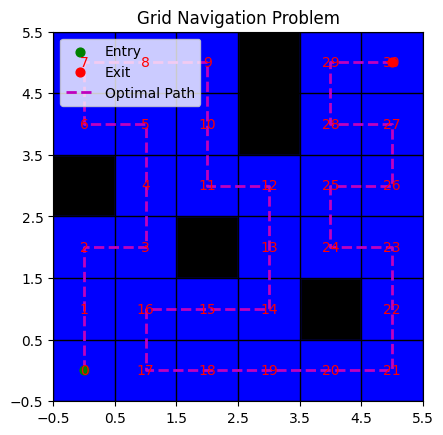

In [8]:
# Visualize the path learned by the trained AI agent
plot_grid(optimal_path, 0.1, grid, obstacle_cells, entry_cell, exit_cell)

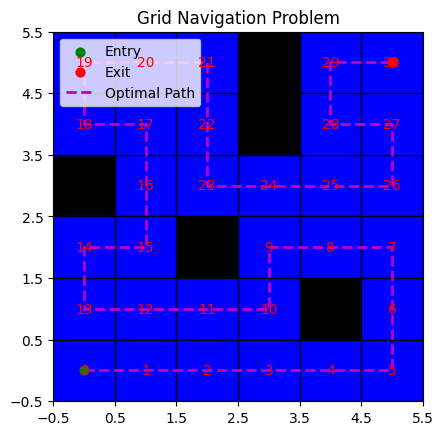

In [9]:
# Define initial Hamiltonian path
visited = [[False] * grid_size for _ in range(grid_size)]
ham_path = []
ham_path = findPath(ini_obs_map, obstacle_cells, entry_cell, exit_cell, visited, ham_path, grid_size, grid_size)
if ham_path:
    plot_grid(ham_path, 0.1, grid, obstacle_cells, entry_cell, exit_cell)

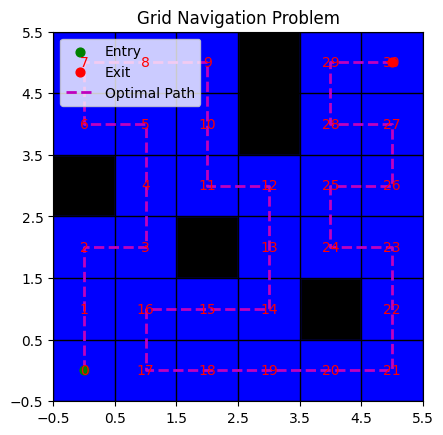

Path reward:  4449


In [10]:
# Visualize the path with highest reward from AI training history
plot_grid(paths_history[np.argmax(rewards_history)], 0.1, grid, obstacle_cells, entry_cell, exit_cell)
print('Path reward: ', np.argmax(rewards_history))

Few suggestions to improve the code for the hamiltonian path RL approach:

1. Exploration-Exploitation Tradeoff: In the current implementation, the agent explores the environment using an epsilon-greedy policy. However, you can experiment with different exploration strategies, such as decaying epsilon, softmax exploration, or using more advanced exploration techniques like Upper Confidence Bound (UCB) or Thompson Sampling.

2. Reward Engineering: You can experiment with different reward structures to encourage desired behavior. For example, you can assign higher rewards for reaching unvisited cells or penalize the agent for revisiting previously visited cells. Carefully designing the reward structure can significantly impact the agent's learning.

3. Hyperparameter Tuning: The code currently uses fixed hyperparameters such as learning rate, discount factor, and exploration rate. It would be beneficial to perform hyperparameter tuning to find the best values for these parameters. Techniques like grid search or Bayesian optimization can be employed to systematically search for optimal hyperparameter values.

4. Model Architecture: For more complex environments or larger grid sizes, you may consider using deep reinforcement learning algorithms such as Deep Q-Networks (DQN) or Deep Deterministic Policy Gradient (DDPG). These algorithms utilize neural networks as function approximators to handle high-dimensional state spaces.

5. Experience Replay: Implementing experience replay can help improve the agent's learning by randomly sampling and replaying past experiences. This can lead to more efficient learning and better utilization of experience.

6. Parallelization: If you have access to parallel computing resources, you can consider parallelizing the training process by training multiple agents in parallel. This can speed up the learning process and allow for exploration of a larger portion of the state-action space.

7. Advanced Techniques: There are more advanced reinforcement learning algorithms and techniques that you can explore, such as Proximal Policy Optimization (PPO), Trust Region Policy Optimization (TRPO), or using hierarchical reinforcement learning approaches.